In [0]:
import pandas as pd
import numpy as np
import csv

%tensorflow_version 2.x
import tensorflow as tf
tf.__version__
assert tf.__version__ >= "2.0"

from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
x_train = pd.read_csv('/content/drive/My Drive/bilstm_data/x_train.csv')
x_test = pd.read_csv('/content/drive/My Drive/bilstm_data/x_test.csv')
x_val = pd.read_csv('/content/drive/My Drive/bilstm_data/x_val.csv')


y_train = pd.read_csv('/content/drive/My Drive/bilstm_data/y_train.csv')
y_test = pd.read_csv('/content/drive/My Drive/bilstm_data/y_test.csv')
y_val = pd.read_csv('/content/drive/My Drive/bilstm_data/y_val.csv')


In [0]:
texts = x_train['article_text'].values
texts_test = x_test['article_text'].values

In [0]:
texts_val = x_val['article_text'].values
labels_val = y_val['label'].values

In [0]:
labels_test = y_test['label'].values
labels = y_train['label'].values

In [0]:
print(labels.shape, labels_test.shape, labels_test.shape)

(5746,) (3429,) (3429,)


In [0]:
len(y_test.loc[y_test['label']==0])

3076

In [0]:
len(y_test.loc[y_test['label']==1])

353

In [0]:
MAX_NUM_WORDS = 3000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 512 # max number of words in a review to use
# done for word length 64, 128, 256 and 512

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_train = Tokenizer(num_words=MAX_NUM_WORDS) #convert word(string to int)
tokenizer_train.fit_on_texts(texts) 
sequences = tokenizer_train.texts_to_sequences(texts) 

word_index = tokenizer_train.word_index #convert this to dict
print('Found %s unique tokens.' % len(word_index))


Found 85423 unique tokens.


In [0]:
sequences3 = tokenizer_train.texts_to_sequences(texts_val) 
sequences_test = tokenizer_train.texts_to_sequences(texts_test)

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (5746, 512)
Shape of label tensor: (5746, 2)


In [0]:
data2 = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
labels2 = to_categorical(np.asarray(labels_test))
print('Shape of data tensor:', data2.shape)
print('Shape of label tensor:', labels2.shape)

data3 = pad_sequences(sequences3, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
labels3 = to_categorical(np.asarray(labels_val))
print('Shape of data tensor:', data3.shape)
print('Shape of label tensor:', labels3.shape)


Shape of data tensor: (3429, 512)
Shape of label tensor: (3429, 2)
Shape of data tensor: (639, 512)
Shape of label tensor: (639, 2)


In [0]:
x_train = data
y_train = labels

x_val = data3
y_val = labels3

x_test = data2
y_test = labels2

In [0]:
print(y_train.shape, y_val.shape, y_test.shape)

(5746, 2) (639, 2) (3429, 2)


In [0]:
GLOVE_DIR='drive/My Drive/yelp_review_polarity_csv/'

import os
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1917494 word vectors.


In [0]:
EMBEDDING_DIM = 300 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, TimeDistributed, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = ModelCheckpoint('lstm256.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)

x = (LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(2, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)


In [0]:
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 300)          25627200  
_________________________________________________________________
lstm (LSTM)                  (None, 512, 64)           93440     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130   

In [0]:
history = model.fit(x_train, y_train, validation_data=[x_val, y_val], epochs=10, callbacks=[es, mc])

Train on 5746 samples, validate on 639 samples
Epoch 1/10
5728/5746 [============================>.] - ETA: 0s - loss: 0.5028 - accuracy: 0.7495
Epoch 00001: val_accuracy improved from -inf to 0.87950, saving model to lstm256.h5
5746/5746 [==============================] - 126s 22ms/sample - loss: 0.5022 - accuracy: 0.7499 - val_loss: 0.3211 - val_accuracy: 0.8795
Epoch 2/10
5728/5746 [============================>.] - ETA: 0s - loss: 0.3456 - accuracy: 0.8609
Epoch 00002: val_accuracy did not improve from 0.87950
5746/5746 [==============================] - 120s 21ms/sample - loss: 0.3452 - accuracy: 0.8611 - val_loss: 0.3446 - val_accuracy: 0.8388
Epoch 3/10
5728/5746 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.8856
Epoch 00003: val_accuracy improved from 0.87950 to 0.90141, saving model to lstm256.h5
5746/5746 [==============================] - 123s 21ms/sample - loss: 0.2858 - accuracy: 0.8858 - val_loss: 0.2447 - val_accuracy: 0.9014
Epoch 4/10
5728/574

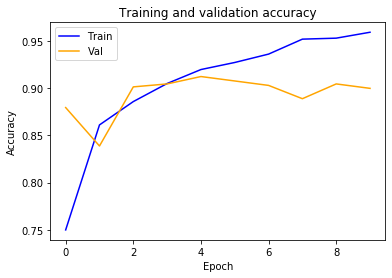

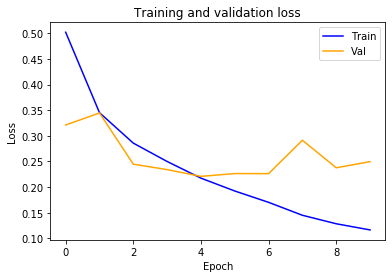

In [0]:
import matplotlib.pyplot as plt

def plot(history):
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

In [0]:
y_test_new = np.argmax(y_test, axis=1)
y_test[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [0]:
y_test_new[0:5]

array([0, 0, 0, 1, 0])

In [0]:
from tensorflow.keras.models import load_model

saved_model = load_model('/content/lstm256.h5')

In [0]:
prediction = saved_model.predict(x_test)
prediction[0:5]

array([[0.9866485 , 0.01335149],
       [0.9920008 , 0.00799913],
       [0.9800189 , 0.01998107],
       [0.03232907, 0.967671  ],
       [0.98491883, 0.0150812 ]], dtype=float32)

In [0]:
y_pred=np.argmax(prediction, axis=1)

In [0]:
sum(y_pred)

661

In [0]:
sum(y_test_new)

353

In [0]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test_new,y_pred)
print('Confusion Matrix : \n', cm1)

Confusion Matrix : 
 [[2746  330]
 [  22  331]]


In [0]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test_new, y_pred, average='macro'))
print(precision_recall_fscore_support(y_test_new, y_pred, average='weighted'))

(0.7464042263867148, 0.915197434584483, 0.7963136216176809, None)
(0.9414753697254472, 0.8973461650627005, 0.9102314749513406, None)


In [0]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test_new, y_pred).ravel()
pre = tp / (tp + fp)
rec = tp / (tp + fn)
tnr = tn / (tn + fp)
acc = (tp + tn)/ (tp + tn + fp + fn)
balanced_acc = (rec + tnr) / 2
f1 = 2 * (pre * rec)/(pre+rec)

print(pre, rec, tnr, acc, balanced_acc, f1)

0.5007564296520424 0.9376770538243626 0.8927178153446034 0.8973461650627005 0.915197434584483 0.6528599605522682


In [0]:
print(tp, tn, fp, fn)

331 2746 330 22


In [0]:
import math
num = (tp*tn - fp*fn)
den = math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(num, den)
mcc = num/den
print(mcc)

901666 1409497.438289265
0.6397074414653566
